## calculo de sistema de almacenamiento de energia


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



2023-09-06 20:55:32.337629: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 20:55:32.338674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 20:55:32.359130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 20:55:32.359957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 20:55:32.731431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [20]:

# importar datos xls de generacion de energia PPC

df = pd.read_excel('gen_2022.xlsx', sheet_name='Datos_Potencia_2022')
# join Date and Time into one column and convert to datetime using strptime
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
# drop Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df.set_index('DateTime', inplace=True)
# calcular energia en Kw/h
df['Energia Kwh'] = df['Valle - PPC - TOTAL AC ACTIVE POWER (kW)'] / 60
# agrupar ene rgia cada 5 minutos
df = df.resample('5T').sum()
# dividir la columna de Valle - PPC - ACTIVE POWER SETPOINT (kW) entre 5
df["Valle - PPC - ACTIVE POWER SETPOINT (kW)"] = df["Valle - PPC - ACTIVE POWER SETPOINT (kW)"] / 5
# Eliminar columna Valle - PPC - TOTAL AC ACTIVE POWER (kW)	
df.drop(['Valle - PPC - TOTAL AC ACTIVE POWER (kW)'], axis=1, inplace=True)

# importar datos xls de radiacion solar
df2 = pd.read_excel('gen_2022.xlsx', sheet_name='Datos_Recurso_Solar_2022')
# join Date and Time into one column and convert to datetime using strptime
df2['DateTime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Time'].astype(str))
# drop Date and Time columns
df2.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df2.set_index('DateTime', inplace=True)

# importar datos xls de temperatura
df3 = pd.read_excel('gen_2022.xlsx', sheet_name='temperatura')
# join Date and Time into one column and convert to datetime using strptime
df3['DateTime'] = pd.to_datetime(df3['Date'].astype(str) + ' ' + df3['Time'].astype(str))
# drop Date and Time columns
df3.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df3.set_index('DateTime', inplace=True)

# agregar columan de Irradiancia media (W/m2) de df2 a df
df['Irradiancia media (W/m2)'] = df2['Irradiancia media (W/m2)']
# agregar columan de Temperatura media (°C) de df3 a df
df['Temperatura media (°C)'] = df3['Temperatura panel promedio - (ºC)']


In [21]:
# create from datetime index a column of hours,monts,day
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Day'] = df.index.day
df.head()


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day
DateTime,,,,,,,
2022-01-01 00:00:00,50000.0,-10.544850,NaN,NaN,0,1,1
2022-01-01 00:05:00,50000.0,-10.526300,-3.127231,19.325083,0,1,1
2022-01-01 00:10:00,50000.0,-10.530717,-3.089154,19.282083,0,1,1
2022-01-01 00:15:00,50000.0,-10.671283,-2.865615,19.229000,0,1,1
2022-01-01 00:20:00,50000.0,-10.486217,-2.904385,19.199667,0,1,1


In [41]:
df.describe()

,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day
count,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000
mean,46257.157935,956.469848,257.519949,33.052690,11.500000,6.526027,15.720548
std,10077.858155,1337.802214,351.309591,12.334228,6.922219,3.447868,8.796289
min,0.000000,-31.141667,-7.592636,0.000000,0.000000,1.000000,1.000000
25%,50000.000000,-10.683683,-2.094298,23.418814,5.750000,4.000000,8.000000
50%,50000.000000,-7.926475,1.310923,26.923650,11.500000,7.000000,16.000000
75%,50000.000000,1803.098487,524.289976,43.943000,17.250000,10.000000,23.000000
max,62000.000000,4193.457283,1229.496167,64.681583,23.000000,12.000000,31.000000


In [22]:
# Funciones
# Funcion de imputacion de datos faltantes
def imputacion_lineal(df):
    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
    df.fillna(0, inplace=True)
    return df

# Funcion para reemplazar valores NaN por 0
def reemplazar_nan(df):
    df.fillna(0, inplace=True)
    return df

In [42]:
# Imputacion de NaNs usando interpolacion lineal
df = imputacion_lineal(df)
# replace nan values with 0
df.fillna(0, inplace=True)
# count number of NaN values in dataframe
print(df.isnull().sum())

# Copiar datos de generacion de energia
df_gen = df.copy()
# Eliminar registros donde Valle - PPC - ACTIVE POWER SETPOINT (kW) < 50000
df_gen = df_gen[df_gen['Valle - PPC - ACTIVE POWER SETPOINT (kW)'] >= 50000]
# Eliminar registros donde Energia Kwh <= 0
df_gen = df_gen[df_gen['Energia Kwh'] > 0]
# Eliminar registros donde Energia Kwh > 4000
df_gen = df_gen[df_gen['Energia Kwh'] <= 4000]
# Eliminar registros donde Irradiancia media (W/m2) <= 20
df_gen = df_gen[df_gen['Irradiancia media (W/m2)'] > 20]
df_gen.head()

Valle - PPC - ACTIVE POWER SETPOINT (kW)    0
Energia Kwh                                 0
Irradiancia media (W/m2)                    0
Temperatura media (°C)                      0
Hour                                        0
Month                                       0
Day                                         0
dtype: int64


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day
DateTime,,,,,,,
2022-01-01 06:30:00,50000.0,90.330383,33.933769,16.942273,6,1,1
2022-01-01 06:35:00,50000.0,152.545200,57.114308,16.980250,6,1,1
2022-01-01 06:40:00,50000.0,218.782100,81.989923,17.259667,6,1,1
2022-01-01 06:45:00,50000.0,296.787717,109.117077,17.669417,6,1,1
2022-01-01 06:50:00,50000.0,416.128133,132.461231,18.132000,6,1,1


In [43]:
# Function to split data into train, test and validation sets
def train_test_val_split(df):
    # split data into train and test sets
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    # split train data into train and validation sets
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    return train, test, val

# split data into train, test and validation sets
train, test, val = train_test_val_split(df_gen)

# split data into X and y , x is Irradiancia media (W/m2)	and Temperatura media (°C)	, y is Energia Kwh
X_train = train[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Hour', 'Month', 'Day']]
y_train = train['Energia Kwh']
X_test = test[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Hour', 'Month', 'Day']]
y_test = test['Energia Kwh']
X_val = val[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Hour', 'Month', 'Day']]
y_val = val['Energia Kwh']

# normalizar datos usando StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



In [44]:
# modelo de regresion polinomial para la generacion de energia
# create linear regression model
model_poly = LinearRegression()
poly_features = PolynomialFeatures(degree=4)

def poly_reg_model(X_train, y_train, X_test, y_test, X_val, y_val, model=model_poly, poly_features=poly_features):

    # fit and transform X_train
    X_train_poly = poly_features.fit_transform(X_train)
    # transform X_test
    X_test_poly = poly_features.transform(X_test)
    # transform X_val
    X_val_poly = poly_features.transform(X_val)
    # fit model on training data
    model.fit(X_train_poly, y_train)
    # predict on test data
    y_pred = model.predict(X_test_poly)
    # predict on validation data
    y_pred_val = model.predict(X_val_poly)
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # calculate R2 score
    r2 = r2_score(y_test, y_pred)
    # calculate RMSE for validation data
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    # calculate R2 score for validation data
    r2_val = r2_score(y_val, y_pred_val)
    return rmse, r2, rmse_val, r2_val, model

# calculate RMSE and R2 score for polynomial regression model
rmse, r2, rmse_val, r2_val, model_poly = poly_reg_model(X_train, y_train, X_test, y_test, X_val, y_val)

# print RMSE and R2 score
print('RMSE for test data:', rmse)
print('R2 score for test data:', r2)
print('RMSE for validation data:', rmse_val)
print('R2 score for validation data:', r2_val)

RMSE for test data: 220.65953178593796
R2 score for test data: 0.9685690190240316
RMSE for validation data: 228.22397079697308
R2 score for validation data: 0.9666754977094891


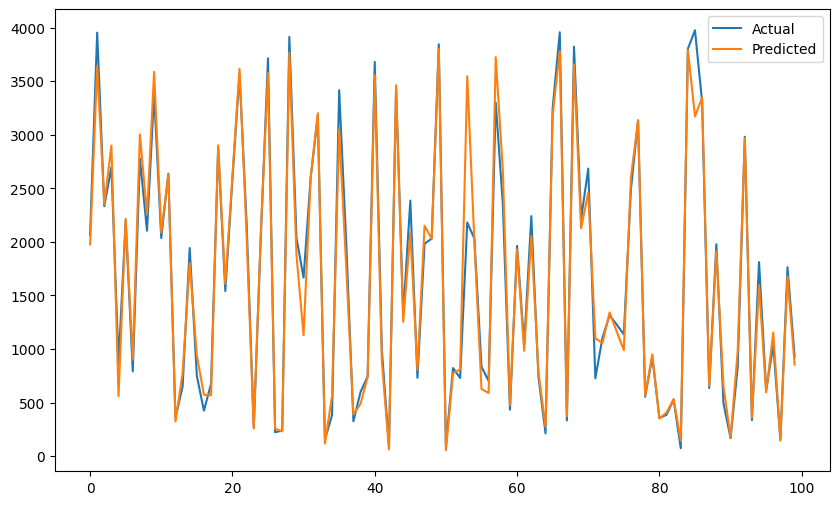

In [45]:
y_pred_poli = model_poly.predict(poly_features.transform(X_test))
a = 0
b = 100 + a
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[a:b], label='Actual')
plt.plot(y_pred_poli[a:b], label='Predicted')
plt.legend()
plt.show()




In [46]:
#  agregar columna de generacion de energia predicha a df
# agregar columna de generacion de energia predicha a df
df_final = df.copy()
df_final['Energia Kwh predicha (Poly)'] = model_poly.predict(poly_features.transform(scaler.transform(df[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Hour', 'Month', 'Day']])))
df_final.head()


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day,Energia Kwh predicha (Poly)
DateTime,,,,,,,,
2022-01-01 00:00:00,50000.0,-10.544850,0.000000,0.000000,0,1,1,-1785.702834
2022-01-01 00:05:00,50000.0,-10.526300,-3.127231,19.325083,0,1,1,-218.984713
2022-01-01 00:10:00,50000.0,-10.530717,-3.089154,19.282083,0,1,1,-220.832734
2022-01-01 00:15:00,50000.0,-10.671283,-2.865615,19.229000,0,1,1,-223.649878
2022-01-01 00:20:00,50000.0,-10.486217,-2.904385,19.199667,0,1,1,-224.713853


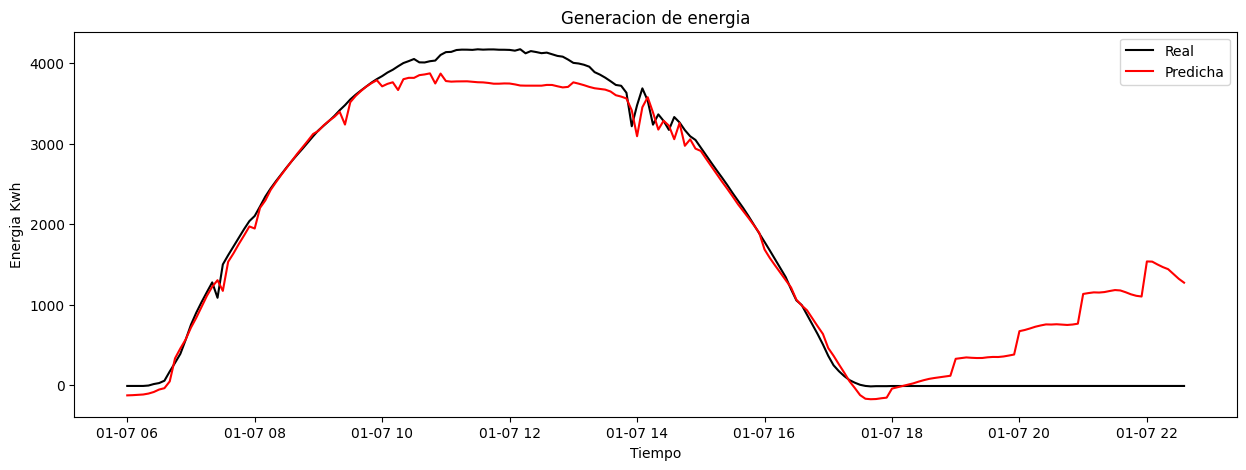

In [47]:
# plot Energia Kwh vs Energia Kwh Pred
plt.figure(figsize=(15,5))
a = 1800
b = a+200
# graficar primeros 100 registros con index
plt.plot(df.index[a:b], df_final['Energia Kwh'][a:b], color='black', label='Real')
plt.plot(df.index[a:b], df_final['Energia Kwh predicha (Poly)'][a:b], color='red', label='Predicha')
plt.title('Generacion de energia')
plt.xlabel('Tiempo')
plt.ylabel('Energia Kwh')
plt.legend()
plt.show()